In [153]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from PIL import Image

In [154]:
#select the mode of panoptic
#set the path of picture/mask/label
panoptic_mode = int(input("Select the mode of panoptic: 1 for DETR, 2 for SETR: "))
if panoptic_mode == 1:
    Filepath = './DETR_result/'
    image1 = cv2.imread('image1.jpg')
    image2 = cv2.imread('image2.jpg')
    mask_label_path1 = Filepath + 'image1/'
    mask_label_path2 = Filepath + 'image2/'
    
elif panoptic_mode == 2:
    Filepath = './SETR_result/'
    image1 = cv2.imread('image1.jpg')
    image2 = cv2.imread('image2.jpg')
    mask_label_path1 = Filepath + 'image1/'
    mask_label_path2 = Filepath + 'image2/'

Select the mode of panoptic: 1 for DETR, 2 for SETR:  1


In [155]:
# create a dictionary to store the mask and label and category
def read_masks_and_labels(mask_label_path):
    labels = []
    categories = []

    with open(mask_label_path + 'image_categories.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split(',')
            label = parts[0].split(':')[1].strip()
            category = parts[1].split(':')[1].strip()
            labels.append(int(label))
            categories.append(category)

    masks = []
    mask_dict = {}
    
    for i, ID in enumerate (labels):
        filename = 'mask_class_' + str(ID) + '.png'
        mask = cv2.imread(mask_label_path + filename, cv2.IMREAD_GRAYSCALE)
        masks = np.array(mask)
        mask_dict[i] = {'labels': labels[i], 'categories': categories[i], 'masks': masks}
        
    return mask_dict

# Use the function to read masks and labels
mask_dict1 = read_masks_and_labels(mask_label_path1)
mask_dict2 = read_masks_and_labels(mask_label_path2)

In [156]:
print(mask_dict1[1])
# print(mask_dict2)

{'labels': 17, 'categories': 'horse', 'masks': array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)}


In [157]:
#SIFT
#create the feature point
# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

In [179]:
def process_image(gray, mask):
    mask = cv2.resize(mask, (gray.shape[1], gray.shape[0]))

    gray_array = np.array(gray)
    mask_array = np.array(mask)

    # Ensure the mask is binary (i.e., contains only 0s and 1s)
    binary_mask = (mask_array > 0).astype(np.uint8)

    # Perform dilation on the binary mask
    kernel = np.ones((3, 3), np.uint8)
    dilated_mask = cv2.dilate(binary_mask, kernel, iterations=5)

    # Use the mask to crop the grayscale image
    cropped_gray = gray_array * dilated_mask

    # Convert the cropped result back to an image
    cropped_gray_image = Image.fromarray(cropped_gray)
    
    return cropped_gray_image


In [186]:
# Create a dictionary to store the processed images and their categories
processed_images1 = {}

# Assuming gray_images is a list of your grayscale images and mask_dicts is a list of your mask dictionaries
for i, mask in enumerate(mask_dict1):
    # Process the image
    processed_image = process_image(gray1, mask_dict1[i]['masks'])
    processed_image = np.array(processed_image)
    # Get the category for this image
    category = mask_dict1[i]['categories']
    
    # Save the processed image and its category to the dictionary
    processed_images1[i] = {'category': category, 'image': processed_image}

# Create a dictionary to store the processed images and their categories
processed_images2 = {}

# Assuming gray_images is a list of your grayscale images and mask_dicts is a list of your mask dictionaries
for i, mask in enumerate(mask_dict2):
    # Process the image
    processed_image = process_image(gray2, mask_dict2[i]['masks'])
    processed_image = np.array(processed_image)
    # Get the category for this image
    category = mask_dict2[i]['categories']
    
    # Save the processed image and its category to the dictionary
    processed_images2[i] = {'category': category, 'image': processed_image}

In [187]:
print(processed_images1[0])

{'category': 'person', 'image': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


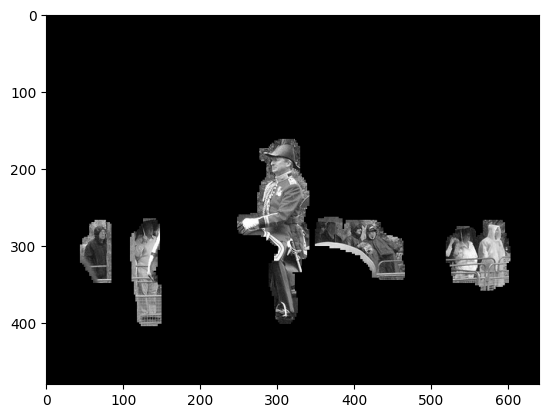

In [189]:
plt.imshow(processed_images1[0]['image'], cmap='gray')

In [168]:
#use the same label mask to seperate the picture's feature point
# Initialize the feature detector and extractor (e.g., SIFT)
sift = cv2.SIFT_create()
# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

In [3]:
#matching each label picture
# Initialize the feature matcher using brute-force matching
bf = cv2.BFMatcher()

# Match the descriptors using brute-force matching
matches = bf.match(descriptors1, descriptors2)

# Select the top N matches
num_matches = 50
matches = sorted(matches, key=lambda x: x.distance)[:num_matches]

# Extract matching keypoints
src_points = np.float32([keypoints1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)

In [4]:
#summary all the matching into one picture 


In [5]:
# Estimate the homography matrix
homography, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

In [ ]:
# Warp the first image using the homography
result = cv2.warpPerspective(image1, homography, (image2.shape[1], image2.shape[0]))

In [ ]:
# Blending the warped image with the second image using alpha blending
alpha = 0.5  # blending factor
blended_image = cv2.addWeighted(result, alpha, image2, 1 - alpha, 0)

# Display the blended image
cv2.imshow('Blended Image', blended_image)
cv2.waitKey(0)
cv2.destroyAllWindows()